# <center> Modelo de ML </center>

## 1. Librerías

In [1]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import evaluate_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
warnings.simplefilter('ignore')

## 2. Configuraciones

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
plt.rcParams["figure.figsize"] = (8, 5)
sns.set_theme(style = "whitegrid")

## 3. Carga de datos

In [5]:
DATA_PATH = "../Data/Refined/Model input/refined_data.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (6870, 11)


,codCliente,codPoliza,Edad,Ramo,Y,Salud,Vida,Autos,Cumplimiento,Patrimoniales,Otros
0,37,69,31,Vida,Autos,0,1,0,0,0,0
1,37,80568,31,Autos,Salud,0,1,1,0,0,0
2,84,118023,41,Autos,Vida,0,0,1,0,0,0
3,87,54,42,Vida,Salud,0,1,0,0,0,0
4,1380,15380,36,Autos,Patrimoniales,0,0,1,0,0,0


## 4. Preprocesamiento de datos

### 4.1. Eliminar columnas de ID

In [6]:
id_cols = ["codCliente", "codPoliza"]
for col in id_cols:
    if col in df.columns:
        df = df.drop(columns = col)

### 4.2. Revisar desbalance entre clases

In [7]:
print(df["Y"].value_counts(normalize = True))

Y
Salud            0.346434
Vida             0.258952
Autos            0.220087
Patrimoniales    0.157351
Cumplimiento     0.014556
Otros            0.002620
Name: proportion, dtype: float64


### 4.3. Revisar nulos

In [8]:
df.isna().sum()

Edad             0
Ramo             0
Y                0
Salud            0
Vida             0
Autos            0
Cumplimiento     0
Patrimoniales    0
Otros            0
dtype: int64

### 4.4. Eliminar filas con edad 0

In [9]:
df = df[df['Edad'] > 0]

## 5. Definición features y target

In [10]:
TARGET = "Y"

X = df.copy().drop(columns = TARGET)
y = df[TARGET].copy()

categorical_features = ["Ramo"]
numeric_features = [c for c in X.columns if c not in categorical_features]

X.head()

,Edad,Ramo,Salud,Vida,Autos,Cumplimiento,Patrimoniales,Otros
0,31,Vida,0,1,0,0,0,0
1,31,Autos,0,1,1,0,0,0
2,41,Autos,0,0,1,0,0,0
3,42,Vida,0,1,0,0,0,0
4,36,Autos,0,0,1,0,0,0


## 6. División del conjunto de datos

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.20,
    stratify = y,
    random_state = RANDOM_STATE,
)

print("Train size:", X_train.shape[0])
print("Test size: ", X_test.shape[0])

Train size: 4913
Test size:  1229


## 7. Pipelines de preprocesamiento

In [12]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

preprocess_for_linear = ColumnTransformer(
    transformers = [
        ("preprocess_categorical_features", OneHotEncoder(handle_unknown = "ignore"), categorical_features),
        ("preprocess_numeric_features", StandardScaler(), numeric_features),
    ]
)

preprocess_for_trees = ColumnTransformer(
    transformers = [
        ("preprocess_categorical_features", OneHotEncoder(handle_unknown = "ignore"), categorical_features),
        ("preprocess_numeric_features", "passthrough", numeric_features),
    ]
)

## 8. Modelos

### 8.1. Regresión logística

#### 8.1.1. Definición modelo

In [13]:
logreg_pipeline = Pipeline(
    steps = [
        ("preprocess", preprocess_for_linear),
        ("model", LogisticRegression(
            max_iter = 1000,
            multi_class = "multinomial",
            n_jobs = -1,
            random_state = RANDOM_STATE,
        )),
    ]
)

#### 8.1.2. Ajuste de hiperparámetros

In [14]:
logreg_param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__solver": ["lbfgs", "saga"],
}

logreg_grid_search = GridSearchCV(
    estimator = logreg_pipeline,
    param_grid = logreg_param_grid,
    cv = cv, 
    scoring = {
        "f1_macro": "f1_macro",
        "top_k_accuracy": "top_k_accuracy",
    },
    refit = "top_k_accuracy",
    n_jobs = -1,
    verbose = 2,
)

print("Running GridSearchCV for Logistic Regression...")
logreg_grid_search.fit(X_train, y_train)

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.1s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.2s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.2s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.2s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.1s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.1s
[CV] END ..................model__C=0.01, model__solver=saga; total time=   0.8s
[

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__solver': ['lbfgs', 'saga']}"
,scoring,"{'f1_macro': 'f1_macro', 'top_k_accuracy': 'top_k_accuracy'}"
,n_jobs,-1
,refit,'top_k_accuracy'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('preprocess_categorical_features', ...), ('preprocess_numeric_features', ...)]"


#### 8.1.3. Entrenamiento mejor modelo

Accuracy (k=1): 0.5512
F1-macro: 0.3002

Classification report:
               precision    recall  f1-score   support

        Autos       0.60      0.18      0.28      1061
 Cumplimiento       1.00      0.01      0.03        69
        Otros       0.00      0.00      0.00        13
Patrimoniales       0.58      0.11      0.19       785
        Salud       0.54      0.86      0.66      1734
         Vida       0.56      0.75      0.64      1251

     accuracy                           0.55      4913
    macro avg       0.55      0.32      0.30      4913
 weighted avg       0.57      0.55      0.49      4913


Top-k metrics:
acc@1: 0.5512 | prec@1: 0.5512 | recall@1: 0.5512
acc@2: 0.8524 | prec@2: 0.4262 | recall@2: 0.8524
acc@3: 0.9835 | prec@3: 0.3278 | recall@3: 0.9835
acc@5: 1.0000 | prec@5: 0.2000 | recall@5: 1.0000


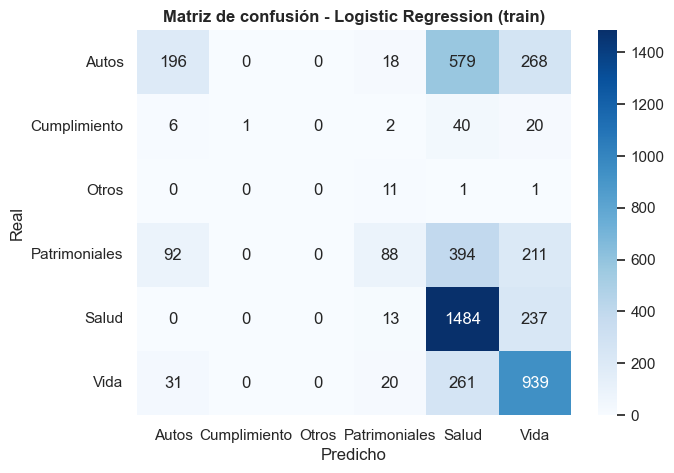

In [15]:
best_logreg_model = logreg_grid_search.best_estimator_
best_logreg_model.fit(X_train, y_train)

joblib.dump(best_logreg_model, "../Data/refined/model output/best_logreg_model.pkl")

logreg_train_results = evaluate_model("Logistic Regression (train)", best_logreg_model, X_train, y_train)

### 8.2. HistGradientBoostingClassifier

#### 8.2.1. Definición del modelo

In [16]:
hgb_pipeline = Pipeline(
    steps = [
        ("preprocess", preprocess_for_trees),
        ("model", HistGradientBoostingClassifier(random_state = RANDOM_STATE)),
    ]
)

#### 8.2.2. Ajuste de hiperparámetros

In [17]:
param_grid = {
    "model__max_depth": [None, 6, 10],
    "model__learning_rate": [0.05, 0.1],
    "model__max_iter": [200, 400],
    "model__min_samples_leaf": [20, 50],
}

grid_search_hgb = GridSearchCV(
    estimator = hgb_pipeline,
    param_grid = param_grid,
    cv = cv,
    scoring = {
        "f1_macro": "f1_macro",
        "top_k_accuracy": "top_k_accuracy",
    },
    refit = "top_k_accuracy",
    n_jobs = -1,
    verbose = 2,
)

print("Running GridSearchCV for HistGradientBoosting...")
grid_search_hgb.fit(X_train, y_train)

Running GridSearchCV for HistGradientBoosting...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=  18.5s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=  18.7s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=  18.7s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=  18.6s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=  18.6s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=50; total time=  18.6s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=50; total time=  18.6s


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [None, 6, ...], 'model__max_iter': [200, 400], 'model__min_samples_leaf': [20, 50]}"
,scoring,"{'f1_macro': 'f1_macro', 'top_k_accuracy': 'top_k_accuracy'}"
,n_jobs,-1
,refit,'top_k_accuracy'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('preprocess_categorical_features', ...), ('preprocess_numeric_features', ...)]"


#### 8.2.3. Entrenamiento mejor modelo

Accuracy (k=1): 0.5770
F1-macro: 0.3997

Classification report:
               precision    recall  f1-score   support

        Autos       0.57      0.30      0.39      1061
 Cumplimiento       1.00      0.01      0.03        69
        Otros       0.67      0.31      0.42        13
Patrimoniales       0.70      0.13      0.22       785
        Salud       0.57      0.82      0.67      1734
         Vida       0.58      0.80      0.67      1251

     accuracy                           0.58      4913
    macro avg       0.68      0.39      0.40      4913
 weighted avg       0.60      0.58      0.53      4913


Top-k metrics:
acc@1: 0.5770 | prec@1: 0.5770 | recall@1: 0.5770
acc@2: 0.8659 | prec@2: 0.4329 | recall@2: 0.8659
acc@3: 0.9880 | prec@3: 0.3293 | recall@3: 0.9880
acc@5: 1.0000 | prec@5: 0.2000 | recall@5: 1.0000


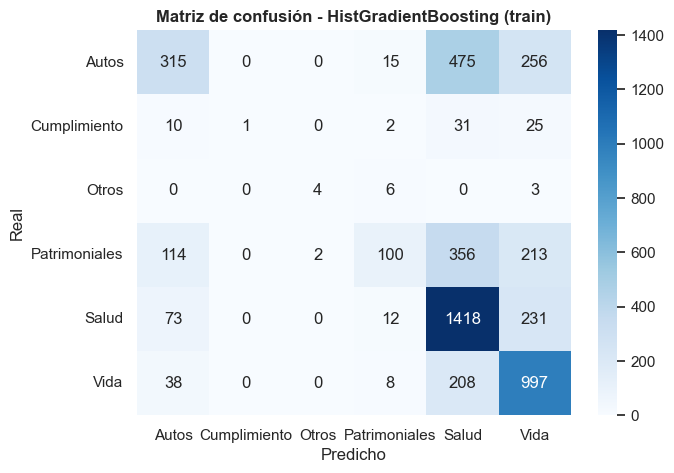

In [18]:
best_hgb_model = grid_search_hgb.best_estimator_
best_hgb_model.fit(X_train, y_train)

joblib.dump(best_hgb_model, "../Data/refined/model output/best_hgb_model.pkl")

hgb_train_results = evaluate_model("HistGradientBoosting (train)", best_hgb_model, X_train, y_train)

### 9. Evaluación mejor modelo

Accuracy (k=1): 0.5248
F1-macro: 0.2923

Classification report:
               precision    recall  f1-score   support

        Autos       0.47      0.25      0.32       265
 Cumplimiento       0.00      0.00      0.00        17
        Otros       0.00      0.00      0.00         4
Patrimoniales       0.53      0.12      0.20       196
        Salud       0.55      0.77      0.64       434
         Vida       0.51      0.70      0.59       313

     accuracy                           0.52      1229
    macro avg       0.34      0.31      0.29      1229
 weighted avg       0.51      0.52      0.48      1229


Top-k metrics:
acc@1: 0.5248 | prec@1: 0.5248 | recall@1: 0.5248
acc@2: 0.8462 | prec@2: 0.4231 | recall@2: 0.8462
acc@3: 0.9797 | prec@3: 0.3266 | recall@3: 0.9797
acc@5: 0.9992 | prec@5: 0.1998 | recall@5: 0.9992


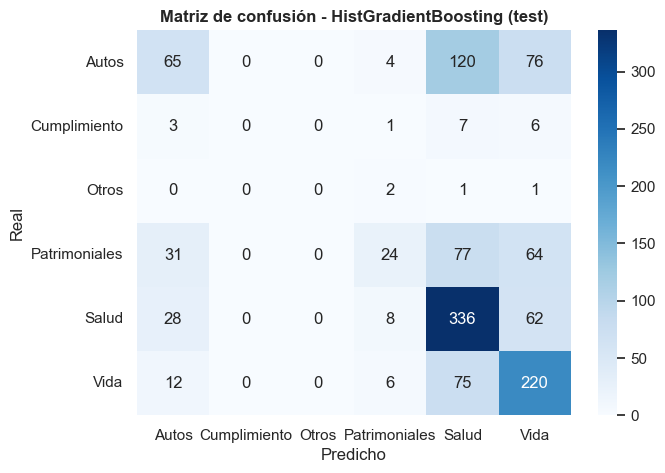

In [19]:
hgb_test_results = evaluate_model("HistGradientBoosting (test)", best_hgb_model, X_test, y_test)